In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve


import FDMethodsSparseMatrix as fdm

Point 1

Finite Difference solver for the 2D Poisson problem:

$-\Delta u=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

Define FD problem and solve with $(a,b)=(0,
pi)$ and

$u(x,y)=sin(x)*sin(y)$

hence

$f=2* sin(x)*sin(y)$

In [4]:
# Domain of data
omega = [0, np.pi]
N=50

# RHS function
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
# Solution to be found
u = lambda x, y : np.sin(x) * np.sin(y)

#FD system
method = fdm.FD_2D(omega, N, rhs)
A, F = method.FD2D_Poisson_Homo()

# solve
uh = spsolve(A,F)

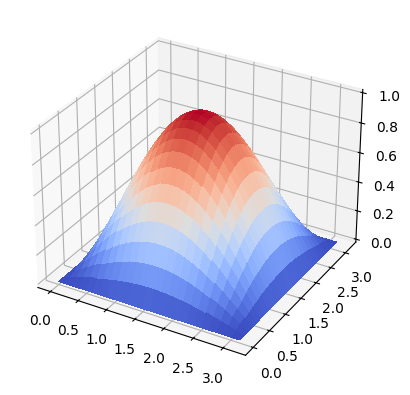

In [5]:
# Prepare data for plotting
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

Now, let's try to see how the error change if mesh get refined

In [26]:
err = np.zeros(3)
step_mesh = np.array([50, 100, 500])

# RHS function
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
# Solution to be found
u = lambda x, y : np.sin(x) * np.sin(y)

omega = [0, np.pi]


for j, NN in enumerate(step_mesh):

    x = np.linspace(omega[0],omega[1],NN+1)
    y = x
    # 2-dim grid
    X, Y = np.meshgrid(x,y)

    #FD system
    method = fdm.FD_2D(omega, NN, rhs)
    A, F = method.FD2D_Poisson_Homo()

    # solve
    uh = spsolve(A,F)
    Uh = uh.reshape((NN+1),(NN+1))

    # compute exact sol
    U = u(X,Y)

    # Print discrete error
    err[j] = np.max(np.max(np.abs(U-Uh)))

c:\Users\matte\myenv_jax_dl\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


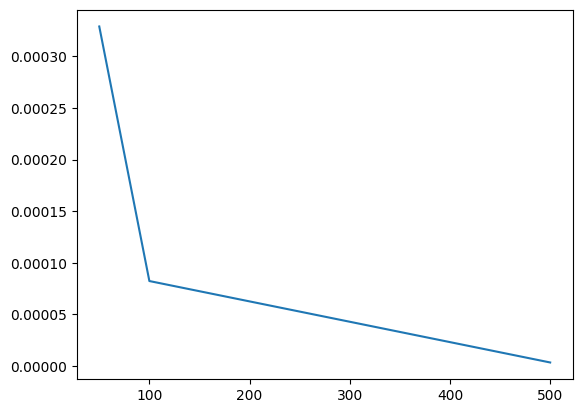

In [27]:
plt.plot(step_mesh, err)

The error decrease if the number of nodes increases

Compute in the standard way the estimate of convergence rate

In [28]:
eoc = [((np.log(err[i-1])-np.log(err[i]))/(np.log(step_mesh[i-1])-np.log(step_mesh[i]))) for i in range(1,len(step_mesh))]
eoc

[np.float64(-2.0002135991042436), np.float64(-2.0000296037194283)]

Here, it is possible to observe the theoretical expectation are respected about 2 order of convergence

Point 2

Implementation of schema for general elliptic equation with homogeneous and not Dirichlet condition are implmented in FDMethodsSparseMatrix file

-$\alpha \Delta u + {\bf b}\cdot \nabla u + c u =f\, $ in $\, \Omega$,

with homogeneous Dirichlet and nonhomogeneous Dirichlet boundary conditions.

Compute the EOC when solution is not known

In [31]:
# Initialize probalm domain and data
omega =[0, np.pi]

# Define functions of RHS 
alpha = 8
bx = 1
by = 1
c_coeff = 4
f = lambda x, y : 2 * np.sin(x) * np.sin(y)

Provide first initialization solution

In [73]:
n_iter = 4 #for computing time
# Define first number of nodes
N=51
# Define grid (initial)
x =np.linspace(omega[0],omega[1],N+1)

method = fdm.FD_2D(omega, N, rhs)
A, F = method.FD2D_GEN_Homo(alpha, bx, by, c_coeff)
# initial solution discrete
uh=spsolve(A,F)
# k_ratio store
k_array = np.zeros(n_iter)

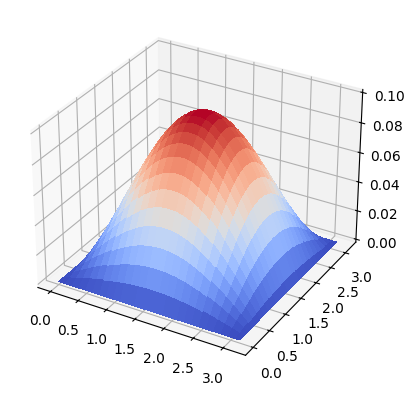

In [74]:
# Prepare data for plotting
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

In [75]:
# Now the actual iterator once the model has been initialized (suppose k = 0.5)
for i in range(1,n_iter):
    N = 2 * N
    method = fdm.FD_2D(omega, N, rhs)
    A, F = method.FD2D_GEN_Homo(alpha, bx, by, c_coeff) 
    uh2=spsolve(A,F)
    # select a point every 2, since it is a point wise comparison, but on same actual (x,y)
    x = np.linspace(omega[0],omega[1],N+1)
    y = x
    uh2_shaped = uh2.reshape((N+1),(N+1))
    uh2_comparison = uh2_shaped[0:N:2,0:N:2]

    k_array[i] = abs(uh2_comparison-Uh[:-1,:-1]).max() # sacrifice on a point to get broadcasting

    Uh = uh2_shaped
    


for i in range(2,len(k_array)):
    print(np.log2(k_array[i-1]/k_array[i])/np.log2(2))

2.000162392277536
2.000027698083846


It is possible to see again that the EOC is 2